<span style="color:blue"> *Unsupervised Progression based PD subtypes * </span>


## Loading libraries and saved data

In [1]:
from pathlib import Path
import sys
import os
PPMI_CLINICAL_GEN_DATA_DIR_INSIDE = Path(os.getcwd()).parent
sys.path.append(str(Path(os.getcwd()).parent))
dataset_name = 'jul1022'

In [2]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from datetime import datetime
import pickle
import copy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

PPMI_CLINICAL_GEN_DATA_DIR_INSIDE = PPMI_CLINICAL_GEN_DATA_DIR_INSIDE / 'generated_data/clinical/ppmi'

with open(PPMI_CLINICAL_GEN_DATA_DIR_INSIDE / 'preprocessed/{}.pkl'.format(dataset_name), 'rb') as f:
    preprocessed_data = pickle.load(f)
    
with open(PPMI_CLINICAL_GEN_DATA_DIR_INSIDE / 'representation_learning/{}.pkl'.format(dataset_name), 'rb') as f:
    representation_learning_data = pickle.load(f)
    
with open(PPMI_CLINICAL_GEN_DATA_DIR_INSIDE / 'clustering/{}.pkl'.format(dataset_name), 'rb') as f:
    clustering_data = pickle.load(f)

input_data = {}
input_data.update(preprocessed_data)
input_data.update(representation_learning_data)
input_data.update(clustering_data)
datasets = input_data['data_names']

In [3]:
input_data['nmf3_projection_cluster']['paper_experiment_replication_BL'][1].var()

Sleep dimension        0.007972
Motor dimension        0.012572
Cognitive dimension    0.002111
dtype: float64

In [4]:
sns.set(context='notebook', style='ticks', font_scale=1.6, font='sans-serif', rc={"lines.linewidth": 1.2})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.rcParams.update({"savefig.format": 'png'})

# plt.style.use('default')
# plt.rcParams.update({'font.size':20})

dset = datasets[0]
Labels_act = input_data['d_M_PD_HC_gmm_chosen'][dset][['GMM_2d_adj']]
palette_progression = {'PDvec3':'orange', 'PDvec2': 'blue', 'PDvec1':'green', 'Non-PD':'red'}
subtype_order = ['PDvec3', 'PDvec2', 'PDvec1', 'Non-PD']
subtype_replace = {'PD_h':'PDvec3', 'PD_m': 'PDvec2', 'PD_l':'PDvec1', 'HC':'Non-PD', 'Control': 'Non-PD'}
subtype_column = {'GMM': 'Subtypes'}
dimension_name = {'Motor dimension': 'Motor disturbance', 'Cognitive dimension': 'Cognitive impairment', 'Sleep dimension': 'Sleep disturbance'}
color_patch = []
circle_patch = []
for lab, color in palette_progression.items():
    color_patch.append(mpatches.Patch(color=color, label=lab))
    # circle_patch.append(plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color, label=lab))

In [5]:
Labels = pd.merge(input_data['d_M_label'][dset], input_data['d_M_label_3d'][dset], left_index=True, right_index=True)
Labels['cat'] = Labels['GMM_2d_adj'].map(lambda x: 'control' if x=='HC' else 'case')
controls = Labels[Labels['cat']=='control'].index
cases = Labels[Labels['cat']=='case'].index
Labels['GMM'] = Labels['GMM_2d_adj']
Labels['GMM'] = Labels['GMM'].map(lambda x: x if x in ['HC', 'PD_m', 'PD_l', 'PD_h'] else np.nan)
Labels = Labels.dropna()

In [6]:
axc = input_data['M_chosen'][datasets[0]].columns.get_level_values(0)

In [7]:
P = input_data['P_d'][dset]
PX = P[['attribute', 'feature']].groupby('feature').agg(lambda x: list(x))# .reset_index()
feature_attribute_mapping = dict(zip(list(PX.index), list(PX['attribute'])))
# feature_attribute_mapping['hopkins_verbal'].remove('HVLTFPUN')
# feature_attribute_mapping['hopkins_verbal'].remove('HVLTFPRL')
feature_attribute_mapping['MCATOT'] = ['MCATOT']

In [8]:
for i,j in feature_attribute_mapping.items():
    print (i, len(j))

aut 7
benton 1
epworth 8
geriatric 1
hopkins_verbal 5
letter_seq 1
moca 8
neuro_cranial 8
quip 11
rem 19
sdm 1
semantic 3
stai 2
updrs1 6
updrs1pq 7
updrs2pq 13
updrs3 35
MCATOT 1


### save some files

In [9]:
Labels_save = Labels[['GMM']].reset_index().copy()
Labels_save.columns = ['PATNO', 'Subtypes']
os.makedirs("../output_files", exist_ok=True)
Labels_save.to_csv('../output_files/PPMI_subtype_labels.csv', index=False)
# Labels_save.to_csv(ROOT_DIR_INSIDE / 'results_data/clinical/ppmi/PPMI_subtype_labels.csv', index=False)
# Labels_save['ID'] = Labels_save['ID'].map(lambda x: 'PP-'+str(x))

In [10]:
input_data['M_chosen'][datasets[0]].shape

(476, 732)

In [11]:
Labels_save['Subtypes'].value_counts()

HC      154
PD_l    134
PD_m    114
PD_h     46
Name: Subtypes, dtype: int64

## 2D Progression Space

In [12]:
visits_list = ['BL', 'V04', 'V06', 'V08', 'V10', 'V12']
dims = 2
df = pd.DataFrame(input_data['nmf_model']['{}'.format(dset)].components_)
cols = input_data['M_chosen'][dset].columns
df.columns = cols
LW = []
for i in visits_list:
    temp = df.loc[:, df.columns.get_level_values(-1)==i]
    temp.columns = temp.columns.get_level_values(0)
    LW.append(temp)

P_2d = pd.concat([i.round(2) for i in LW], axis=0)
K = []
for i in visits_list:
    K.extend(['C{}-'.format(j)+i for  j in range(int(dims))])
P_2d.index = K
P_2d = P_2d.sort_index()

In [13]:
progression_space_2d_adj_list = []
progression_space_2d_transform_list = []
progression_space_2d_actual_list = []
for visit in visits_list:
    if visit== 'V12':
        visit = ''
    else:
        visit = '_' + visit
    temp = input_data['nmf_projection_cluster']['{}{}'.format(dset, visit)][1]
    temp['Subtypes'] = Labels.loc[list(set(temp.index).intersection(Labels.index)), 'GMM']
    progression_space_2d_adj_list.append(temp.dropna().replace(subtype_replace))

In [14]:
df = progression_space_2d_adj_list[0][['Subtypes', 'Motor dimension', 'Cognitive dimension']].copy()
df.columns = ['Subtypes', 'Motor_dimension_BL', 'Cognitive_dimension_BL']

for i in range(1, len(progression_space_2d_adj_list)):
    temp = progression_space_2d_adj_list[i][['Motor dimension', 'Cognitive dimension']].copy()
    temp.columns = [  'Motor_dimension_{}'.format(visits_list[i]), 
                    'Cognitive_dimension_{}'.format(visits_list[i])]
    df = pd.merge(df,temp, left_index=True, right_index=True)
    
df.reset_index().to_csv('../output_files/PD_progression_latent_weights_2d.csv', sep=',', index=False)

### Final Visit-Gaussian plot

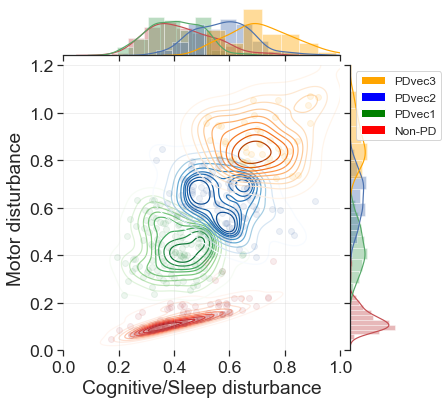

In [15]:


def create_plot_cluster(M_PD_HC_gmm_chosen, xlab, ylab, legends=('PDvec3', 'PDvec2', 'PDvec1', 'Non-PD')):

    x_hc = M_PD_HC_gmm_chosen.loc[M_PD_HC_gmm_chosen.Subtypes.isin(['Non-PD']), xlab]
    y_hc = M_PD_HC_gmm_chosen.loc[M_PD_HC_gmm_chosen.Subtypes.isin(['Non-PD']), ylab]

    x_pd_l = M_PD_HC_gmm_chosen.loc[M_PD_HC_gmm_chosen.Subtypes.isin(['PDvec1']), xlab]
    y_pd_l = M_PD_HC_gmm_chosen.loc[M_PD_HC_gmm_chosen.Subtypes.isin(['PDvec1']), ylab]

    x_pd_m = M_PD_HC_gmm_chosen.loc[M_PD_HC_gmm_chosen.Subtypes.isin(['PDvec2']), xlab]
    y_pd_m = M_PD_HC_gmm_chosen.loc[M_PD_HC_gmm_chosen.Subtypes.isin(['PDvec2']), ylab]

    x_pd_h = M_PD_HC_gmm_chosen.loc[M_PD_HC_gmm_chosen.Subtypes.isin(['PDvec3']), xlab]
    y_pd_h = M_PD_HC_gmm_chosen.loc[M_PD_HC_gmm_chosen.Subtypes.isin(['PDvec3']), ylab]

    plt.ion()
    plt.show()
    plt.pause(0.001)
    a = 0.1
    l = 10
    zo = 0
    columns = 1
    rows = 1
    size_variation = 1.5
    # fig, axislist = plt.subplots(rows, columns, figsize=(4*columns*size_variation, 3*rows*size_variation))
    p = sns.JointGrid(x=x_hc, y=y_hc)
    # sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    p = p.plot_joint(plt.scatter, c="r", alpha=a)
    # p.ax_marg_x.hist(-x_hc, alpha = 0.5, color='r')
    # p.ax_marg_y.hist(y_hc, orientation = 'horizontal', alpha = 0.5, color='r')
    p.plot_marginals(sns.distplot, color='r', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")

    p.x = x_pd_l
    p.y = y_pd_l
    p.plot_joint(plt.scatter, c="g", alpha=a)
    p.plot_marginals(sns.distplot, color='g', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")

    p.x = x_pd_m
    p.y = y_pd_m
    p.plot_joint(plt.scatter, c="b", alpha=a)
    p.plot_marginals(sns.distplot, color='b', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

    p.x = x_pd_h
    p.y = y_pd_h
    p.plot_joint(plt.scatter, c="orange", alpha=a)
    p.plot_marginals(sns.distplot, color='orange', axlabel=[])
    p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Oranges")

    # p.set_axis_labels(xlabel='Cognitive/Sleep disturbance', ylabel='Motor disturbance')
    plt.xlabel(r'{}$\rightarrow$'.format(xlab))
    plt.ylabel(r'{}$\rightarrow$'.format(ylab))
    limit_x = 1.
    limit_y = 1.2
    p.ax_joint.set_ylim(0, limit_y)
    p.ax_joint.set_xlim(0, limit_x)
    p.ax_joint.set_xticks(list(np.arange(0, limit_x+0.05, 0.2)), None)
    p.ax_joint.set_yticks(list(np.arange(0, limit_y+0.05, 0.2)), None)
    p.ax_joint.grid(True, alpha=0.3)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='orange')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    plt.legend((p1, p2, p3, p4), legends, loc='best', prop={'size': 12});
    # sns.despine(ax=p.ax_joint,top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    p.ax_joint.spines['top'].set_visible(False)
    p.ax_joint.spines['right'].set_visible(False)
    p.ax_joint.spines['left'].set_visible(False)
    p.ax_joint.spines['bottom'].set_visible(False)


dimension_name2 = {'Motor dimension': 'Motor disturbance', 'Cognitive dimension': 'Cognitive/Sleep disturbance'}
create_plot_cluster(progression_space_2d_adj_list[-1].rename(columns=dimension_name2), dimension_name2['Cognitive dimension'],  dimension_name2['Motor dimension'])
# plt.savefig('images/Fig5_2D_gmm', dpi=100, bbox_inches = "tight")

### Progression space change with time

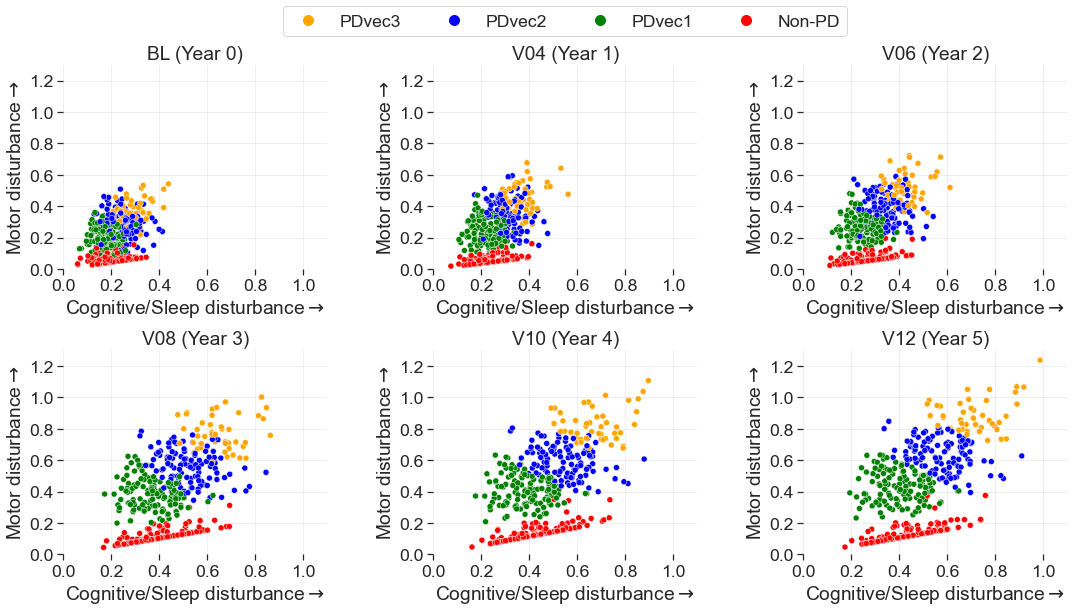

In [16]:
columns = 3
rows = 2
size_variation = 1.5
fig, axislist = plt.subplots(rows, columns, figsize=(4*columns*size_variation, 3*rows*size_variation))
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.4)
axs = axislist.reshape(-1)

for enm, progression_space_3d in enumerate(progression_space_2d_adj_list):
    columns = [('Motor dimension', 'Cognitive dimension')]
    color_patch = []
    for lab, color in palette_progression.items():
        color_patch.append(mpatches.Patch(color=color, label=lab))
    for i in range(1):
        ax = axs[enm + i]
        # print (columns[i][0], np.var(progression_space_3d[columns[i][0]]))
        # print (columns[i][1], np.var(progression_space_3d[columns[i][1]]))
        sns.scatterplot(y=columns[i][0], hue='Subtypes', x=columns[i][1], ax=ax, data=progression_space_3d, palette=palette_progression)
        ax.legend_.remove()
        start_y, start_x = list(progression_space_3d[progression_space_3d['Subtypes']=='Non-PD'].loc[:, columns[i]].mean(axis=0))
        start_y, start_x = 0, 0
        # ax.arrow(0, 0, start_x, start_y, width=0.01, color=palette_progression['Non-PD'], length_includes_head=True)
        for subtype in ['PDvec3', 'PDvec2', 'PDvec1', 'Non-PD']:
        # for subtype in ['PD', 'Non-PD']:
            end_y, end_x = list(progression_space_3d[progression_space_3d['Subtypes']==subtype].loc[:, columns[i]].mean(axis=0))
            # ax.arrow(start_x, start_y, end_x-start_x, end_y-start_y, width=0.007, color=palette_progression[subtype], length_includes_head=True)
            # ax.axvline(x=end_x, ymin=start_y, ymax=1, alpha=0.5, color=palette_progression[subtype])
            # ax.axhline(y=end_y, xmin=start_x, xmax=1, alpha=0.5, color=palette_progression[subtype])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(True, alpha=0.3)
        limit_x = 1.1
        limit_y = 1.3
        ax.set_ylim(0, limit_y)
        ax.set_xlim(0, limit_x)
        ax.set_xticks(list(np.arange(0, limit_x+0.05, 0.2)), None)
        ax.set_yticks(list(np.arange(0, limit_y+0.05, 0.2)), None)
        # print (np.arange(0, 0.65, 0.05))
        empty_string_labels = [str(ep) for ep in range(len(np.arange(0, 0.65, 0.05)))]#['']*len(list(np.arange(0, 0.6, 0.05)))
        empty_string_labels_y = [str(ep) for ep in range(len(np.arange(0, 0.65, 0.05)))]
        ax.set_xlabel(r'{}$\rightarrow$'.format('Cognitive/Sleep disturbance'))
        ax.set_ylabel(r'{}$\rightarrow$'.format('Motor disturbance'))
        
    ax.set_title(visits_list[enm] + ' (Year {})'.format(enm))
    if enm == 0:
        color_patch = []
        circle_patch = []
        for lab, color in palette_progression.items():
            color_patch.append(mpatches.Patch(color=color, label=lab))
            circle_patch.append(plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color, label=lab)[0])
        ax.legend(handles=circle_patch, bbox_to_anchor=(0.8, 1.1), loc='lower left', ncol=4, numpoints=1 )
    # fig.savefig('images/Fig6_progression_space_change', dpi=100, bbox_inches = "tight")

### Variance Loadings Percentage

In [17]:
var = progression_space_2d_adj_list[-1].var() 
print (((var*100) / var.sum()).round(2))

# var = progression_space_2d_actual_list[-1].var() 
# print (((var*100) / var.sum()).round(2))

# var = progression_space_2d_transform_list[-1].var() 
# print (((var*100) / var.sum()).round(2))

Cognitive dimension    23.61
Motor dimension        76.39
dtype: float64


## 3D Progression Space Plots

In [18]:
visits_list = ['BL', 'V04', 'V06', 'V08', 'V10', 'V12']
dims = 3
df = pd.DataFrame(input_data['nmf3_model']['{}'.format(dset)].components_)
cols = input_data['M_chosen'][dset].columns
df.columns = cols
LW = []
for i in visits_list:
    temp = df.loc[:, df.columns.get_level_values(-1)==i]
    temp.columns = temp.columns.get_level_values(0)
    LW.append(temp)

P_3d = pd.concat([i.round(2) for i in LW], axis=0)
K = []
for i in visits_list:
    K.extend(['C{}-'.format(j)+i for  j in range(int(dims))])
P_3d.index = K
P_3d = P_3d.sort_index()

In [19]:
progression_space_3d_adj_list = []
progression_space_3d_actual_list = []
progression_space_3d_transform_list = []
adjust_matrix_weights = {}
for visit in visits_list:
    if visit== 'V12':
        visit = ''
    else:
        visit = '_' + visit
    temp = input_data['nmf3_projection_cluster']['{}{}'.format(dset, visit)][1]
    temp['Subtypes'] = Labels.loc[list(set(temp.index).intersection(Labels.index)), 'GMM']
    # temp.columns = ["Motor dimension", "Sleep dimension", "Cognitive dimension", "Subtypes"]
    progression_space_3d_adj_list.append(temp.dropna().replace(subtype_replace))
    

In [20]:
progression_space_3d_adj_list[-5].var()

Sleep dimension        0.014466
Motor dimension        0.024457
Cognitive dimension    0.003772
dtype: float64

In [21]:
df = progression_space_3d_adj_list[0][['Subtypes', 'Sleep dimension', 'Motor dimension', 'Cognitive dimension']].copy()
df.columns = ['Subtypes', 'Sleep_dimension_BL', 'Motor_dimension_BL', 'Cognitive_dimension_BL']

for i in range(1, len(progression_space_3d_adj_list)):
    temp = progression_space_3d_adj_list[i][['Sleep dimension', 'Motor dimension', 'Cognitive dimension']].copy()
    temp.columns = ['Sleep_dimension_{}'.format(visits_list[i]), 
                    'Motor_dimension_{}'.format(visits_list[i]), 
                    'Cognitive_dimension_{}'.format(visits_list[i])]
    df = pd.merge(df,temp, left_index=True, right_index=True)
    
df.reset_index().to_csv('../output_files/PD_progression_latent_weights_3d.csv', sep=',', index=False)

### Projection Matrix

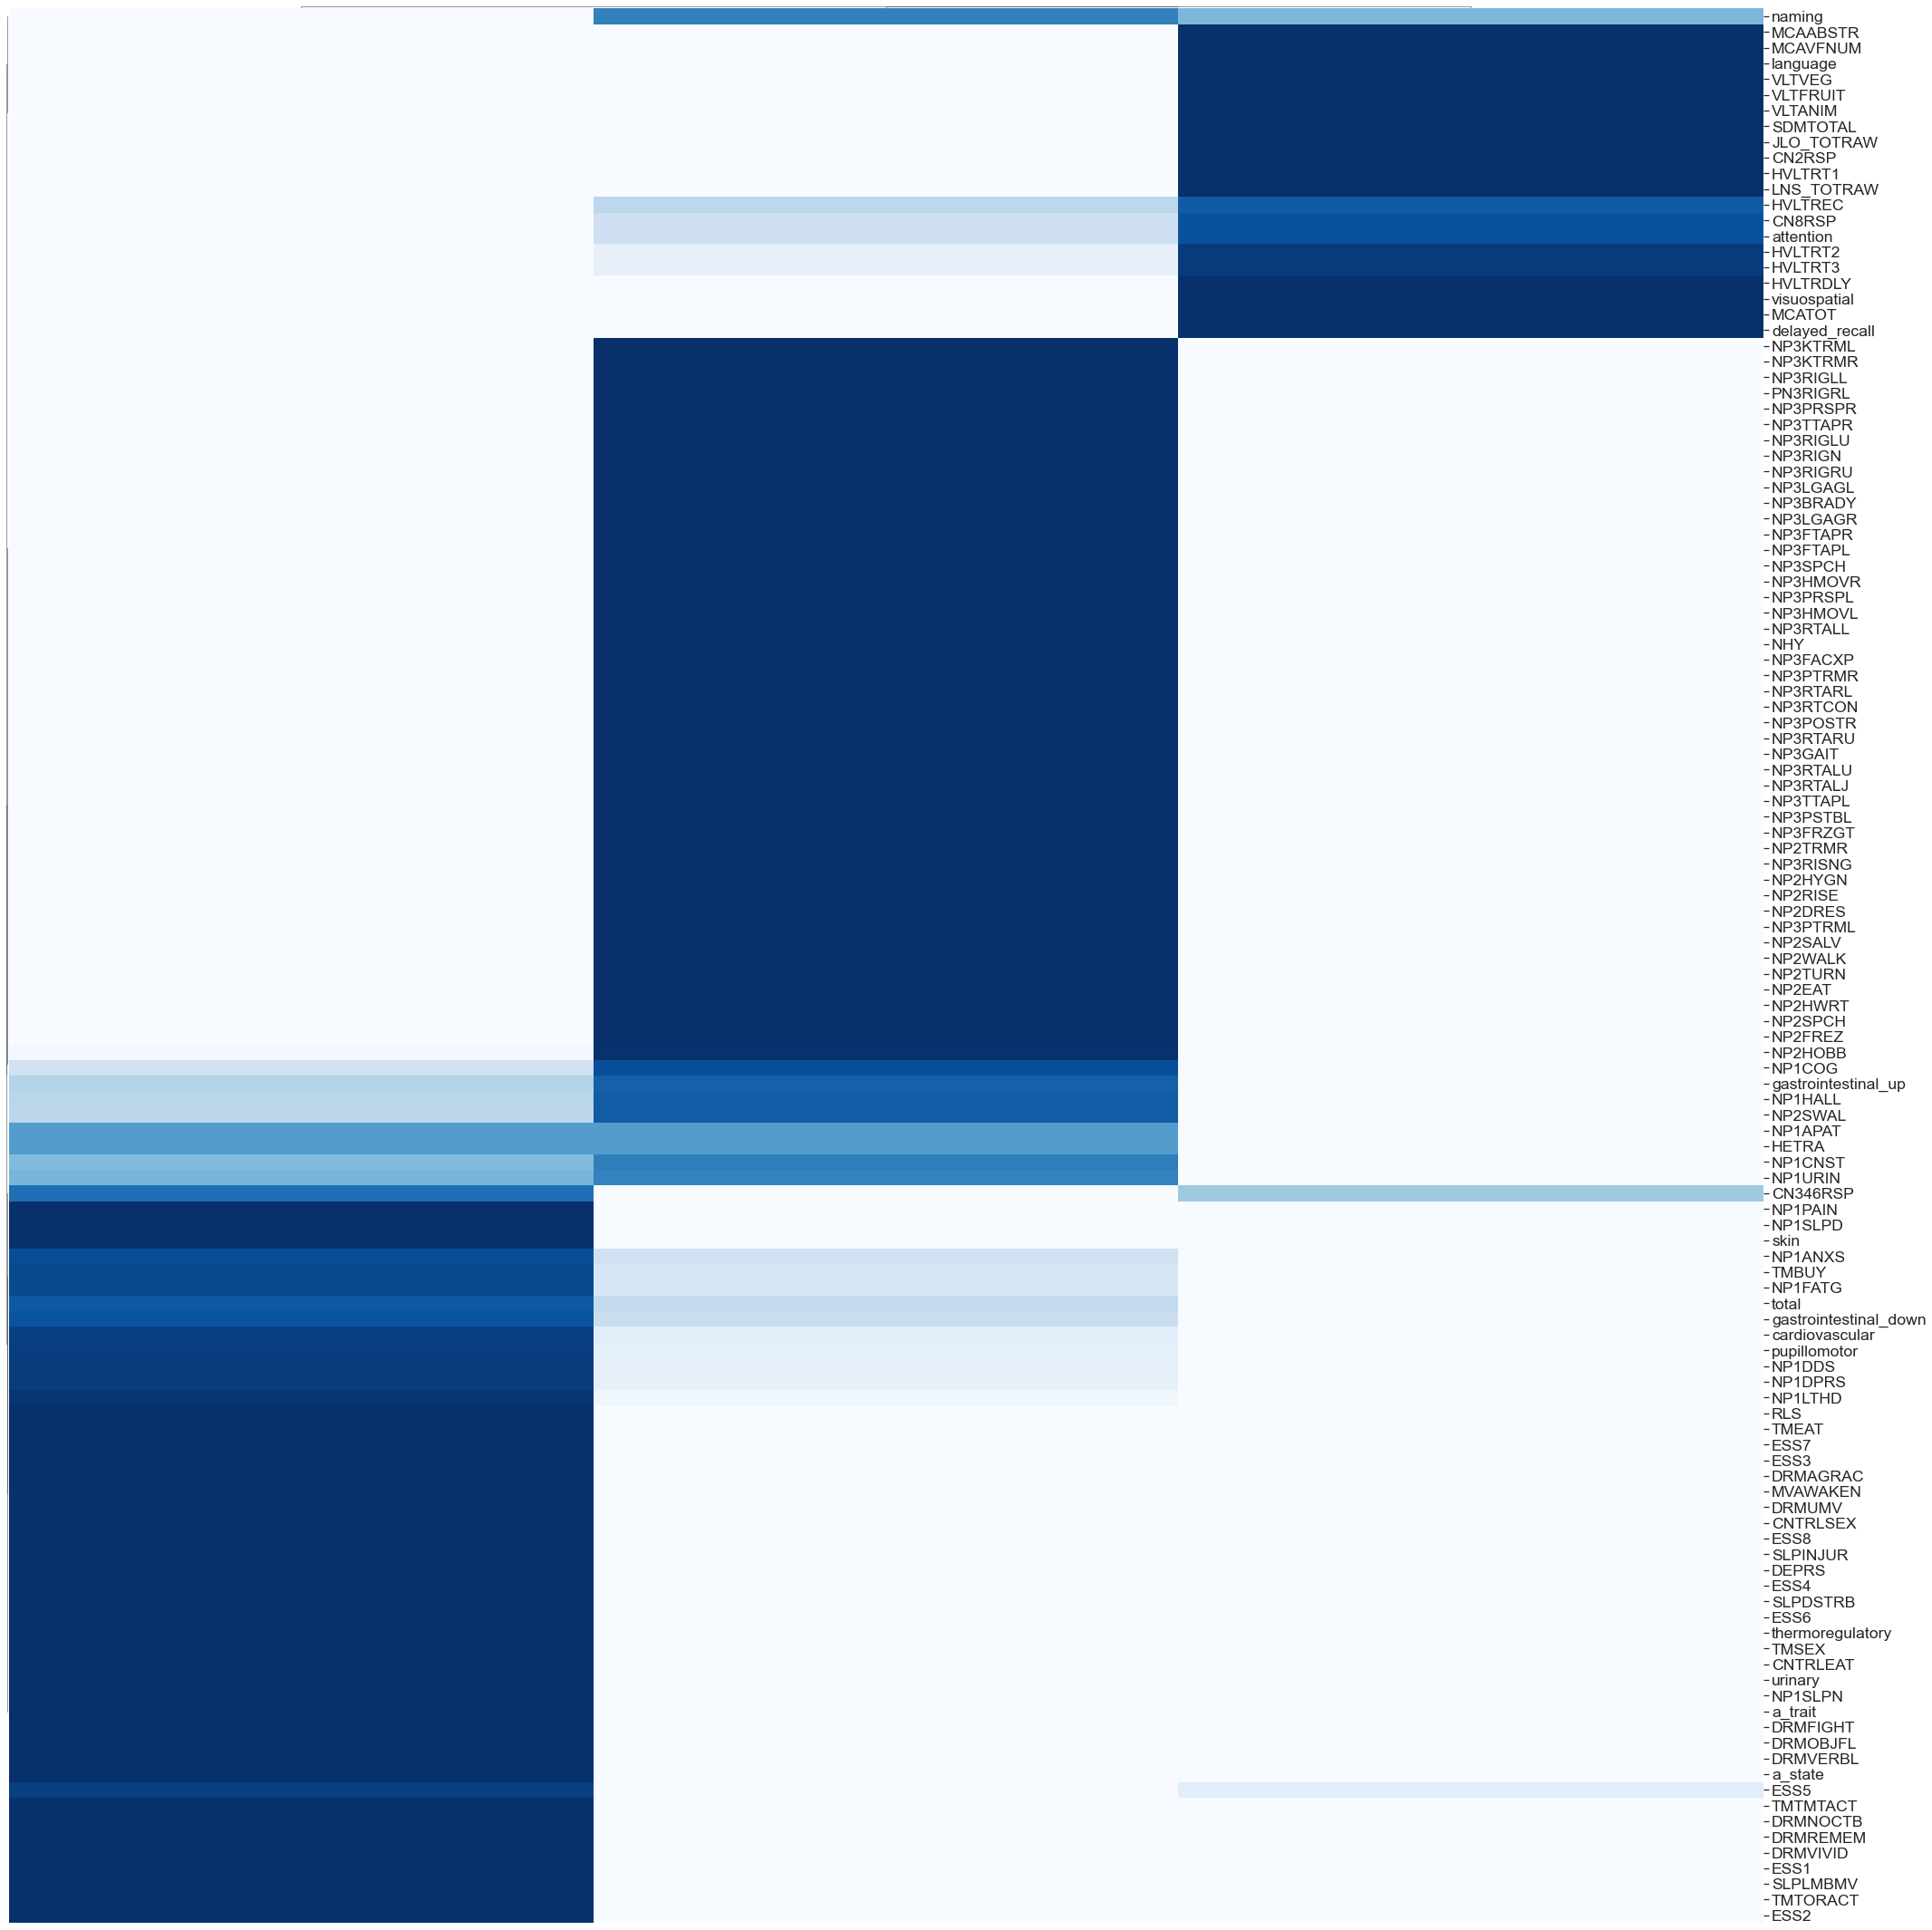

In [22]:
sns.clustermap(P_3d.loc[P_3d.index.str.contains('V12')].T, cmap=plt.cm.Blues, vmin=0, vmax=1,  dendrogram_ratio=0.001, z_score=0,
               col_cluster=True, cbar_pos=None, figsize=(30, 30), standard_scale=None, annot=None, yticklabels=True, xticklabels=False)
# plt.savefig('images/Fig4_dimension_mapping.png', dpi=100)


### Final Visit-3D scatter plot

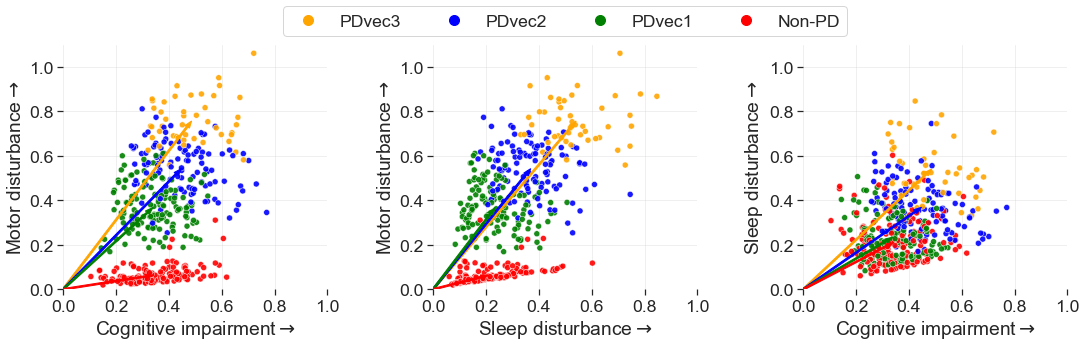

In [23]:
columns = 3
rows = 1
size_variation = 1.5
fig, axislist = plt.subplots(rows, columns, figsize=(4*columns*size_variation, 3*rows*size_variation))
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.4)
axs = axislist.reshape(-1)

for enm, progression_space_3d in enumerate(progression_space_3d_adj_list[-1:]):
    columns = [('Motor dimension', 'Cognitive dimension'), ('Motor dimension', 'Sleep dimension'), ('Sleep dimension', 'Cognitive dimension')]
    label_name = [('Motor disturbance', 'Cognitive impairment'), ('Motor disturbance', 'Sleep disturbance'), ('Sleep disturbance', 'Cognitive impairment')]
    color_patch = []
    for lab, color in palette_progression.items():
        color_patch.append(mpatches.Patch(color=color, label=lab))
    for i in range(3):
        ax = axs[enm*3 + i]
        sns.scatterplot(y=columns[i][0], hue='Subtypes', x=columns[i][1], ax=ax, data=progression_space_3d, palette=palette_progression, alpha=0.9)
        ax.legend_.remove()
        ax.set_xlabel(r'{}$\rightarrow$'.format(label_name[i][1]))
        ax.set_ylabel(r'{}$\rightarrow$'.format(label_name[i][0]))
        start_y, start_x = list(progression_space_3d[progression_space_3d['Subtypes']=='Non-PD'].loc[:, columns[i]].mean(axis=0))
        start_y, start_x = 0, 0
        # ax.arrow(0, 0, start_x, start_y, width=0.01, color=palette_progression['Non-PD'], length_includes_head=True)
        for subtype in ['PDvec3', 'PDvec2', 'PDvec1', 'Non-PD']:
        # for subtype in ['PD', 'Non-PD']:
            end_y, end_x = list(progression_space_3d[progression_space_3d['Subtypes']==subtype].loc[:, columns[i]].mean(axis=0))
            ax.arrow(start_x, start_y, end_x-start_x, end_y-start_y, width=0.007, color=palette_progression[subtype], length_includes_head=True)
            # print (subtype, end_x, end_y)
            # ax.axvline(x=end_x, ymin=start_y, ymax=1, alpha=0.5, color=palette_progression[subtype])
            # ax.axhline(y=end_y, xmin=start_x, xmax=1, alpha=0.5, color=palette_progression[subtype])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.grid(True, alpha=0.3)
        limit_x = 1.0
        limit_y = 1.1
        ax.set_ylim(0, limit_y)
        ax.set_xlim(0, limit_x)
        ax.set_xticks(list(np.arange(0, limit_x+0.05, 0.2)), None)
        ax.set_yticks(list(np.arange(0, limit_y+0.05, 0.2)), None)
        # print (np.arange(0, 0.65, 0.05))
        empty_string_labels = [str(ep) for ep in range(len(np.arange(0, 0.65, 0.05)))]#['']*len(list(np.arange(0, 0.6, 0.05)))
        empty_string_labels_y = [str(ep) for ep in range(len(np.arange(0, 0.65, 0.05)))]
        # ax.set_xticklabels(empty_string_labels)
        # ax.set_yticklabels(empty_string_labels_y)
    # ax.set_title(dset.split('_')[-1])
        if i==0:
            color_patch = []
            circle_patch = []
            for lab, color in palette_progression.items():
                color_patch.append(mpatches.Patch(color=color, label=lab))
                circle_patch.append(plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color, label=lab)[0])
            ax.legend(handles=circle_patch, bbox_to_anchor=(0.8, 1), loc='lower left', ncol=4, numpoints=1 )
            # ax.legend(handles=color_patch, bbox_to_anchor=(0.8, 1.2), loc='lower left', ncol=4, numpoints=1 )
# plt.tight_layout()
# fig.savefig('images/Fig3_detailed_snapshot', dpi=100, bbox_inches = "tight")

### Final Visit-3D plot

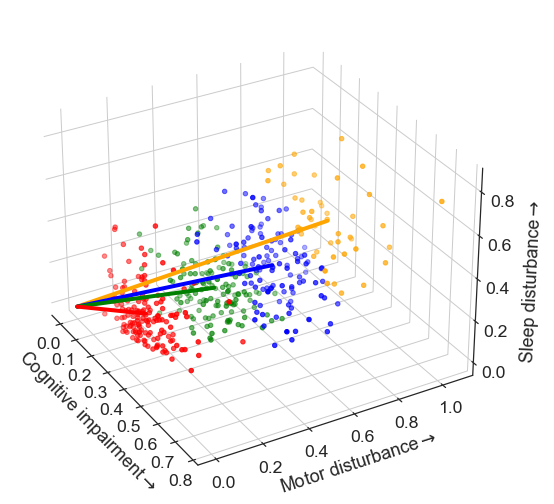

In [24]:
for progression_space_3d in progression_space_3d_adj_list[-1:]:
    # columns = 1
    # rows = 1
    # size_variation = 1.5
    # fig, axislist = plt.subplots(rows, columns, squeeze=True, figsize=(4*columns*size_variation, 3*rows*size_variation))
    # plt.subplots_adjust(hspace=0.2)
    # plt.subplots_adjust(wspace=0.4)
    # axs = axislist.reshape(-1)
    y_axis = 'Motor dimension'
    z_axis = 'Sleep dimension'
    x_axis = 'Cognitive dimension'
    label_name = {'y_axis': 'Motor disturbance', 'x_axis': 'Cognitive impairment', 'z_axis': 'Sleep disturbance'}
    my_dpi=96
    # plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
    # plt.figure(figsize=(40, 20))
    # Keep the 'specie' column appart + make it numeric for coloring
    # progression_space_3d['Subtypes'] = pd.Categorical(progression_space_3d['Subtypes'])
    full_progression_space_3d = progression_space_3d.copy()
    full_progression_space_3d = pd.merge(progression_space_3d, Labels, left_index=True, right_index=True).replace(subtype_replace)
    full_progression_space_3d['Subtypes'] = full_progression_space_3d['GMM_2d_adj']
    
    my_color = full_progression_space_3d['Subtypes'].map(lambda x: palette_progression[x])
    result = full_progression_space_3d.drop('Subtypes', 1)

     # Plot initialisation
    size_variation = 3
    fig = plt.figure(figsize=(4*size_variation, 3*size_variation))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result[x_axis], result[y_axis], result[z_axis], c=my_color)
    nm_color = pd.DataFrame({'index':my_color.index, 'color': list(my_color)})
    g = list(nm_color.groupby('color'))
    for en_t in range(len(g)):
        temp_index = list(g[en_t][1]['index'])
        temp = result.loc[temp_index]
        # ax.plot_trisurf(temp[x_axis], temp[y_axis], temp[z_axis], color=g[en_t][0], linewidth=0., antialiased=True, shade=True)
    for subtype, color in palette_progression.items():
        x_meanpt = full_progression_space_3d.groupby('Subtypes').agg('mean').loc[subtype][x_axis]
        y_meanpt = full_progression_space_3d.groupby('Subtypes').agg('mean').loc[subtype][y_axis]
        z_meanpt = full_progression_space_3d.groupby('Subtypes').agg('mean').loc[subtype][z_axis]
        mean_line = [(0, x_meanpt), (0, y_meanpt), (0, z_meanpt)]
        ax.plot(mean_line[0], mean_line[1], mean_line[2], color=color, linewidth=4, markersize=12)
    
    # make simple, bare axis lines through space:
    xAxisLine = ((min(result[x_axis]), max(result[x_axis])), (0, 0), (0,0))
    # ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'b')
    yAxisLine = ((0, 0), (min(result[y_axis]), max(result[y_axis])), (0,0))
    # ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'b')
    zAxisLine = ((0, 0), (0,0), (min(result[z_axis]), max(result[z_axis])))
    # ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'b')
 
    # label the axes
    ax.set_xlabel(r'{}$\rightarrow$'.format(label_name['x_axis']), labelpad=10, fontsize=18)
    ax.set_ylabel(r'{}$\rightarrow$'.format(label_name['y_axis']), labelpad=10, fontsize=18)
    ax.set_zlabel(r'{}$\rightarrow$'.format(label_name['z_axis']), labelpad=10, fontsize=18)
    # ax.set_xlim(0, 0.3)
    ax.grid(True, alpha=0)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # ax.set_zticklabels([])
    # ax.set_xticklabels([item.get_text() for item in ax.get_xticklabels()],fontsize=8)
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.view_init(elev=30., azim=330)
    
    #  ax.can_zoom(True)
    # fig.savefig('images/Fig3_3d_view', dpi=100, bbox_inches = "tight")
    plt.show()


### Progression space change with time

### Variance Loadings Percentage

In [25]:
var = progression_space_3d_adj_list[-1].var() 
print ('Transformation\n', ((var*100) / var.sum()).round(2))

# var = progression_space_3d_actual_list[-1].var() 
# print ('Actual\n', ((var*100) / var.sum()).round(2))

Transformation
 Sleep dimension        21.81
Motor dimension        63.58
Cognitive dimension    14.61
dtype: float64


### Box plot change in latent weights

In [26]:
A = progression_space_3d_adj_list[-1][['Cognitive dimension', 'Sleep dimension', 'Motor dimension']]#  - progression_space_3d_list[0][['Cognitive dimension', 'Motor dimension', 'Sleep dimension']]
A['Subtypes'] = progression_space_3d_adj_list[-1]['Subtypes']

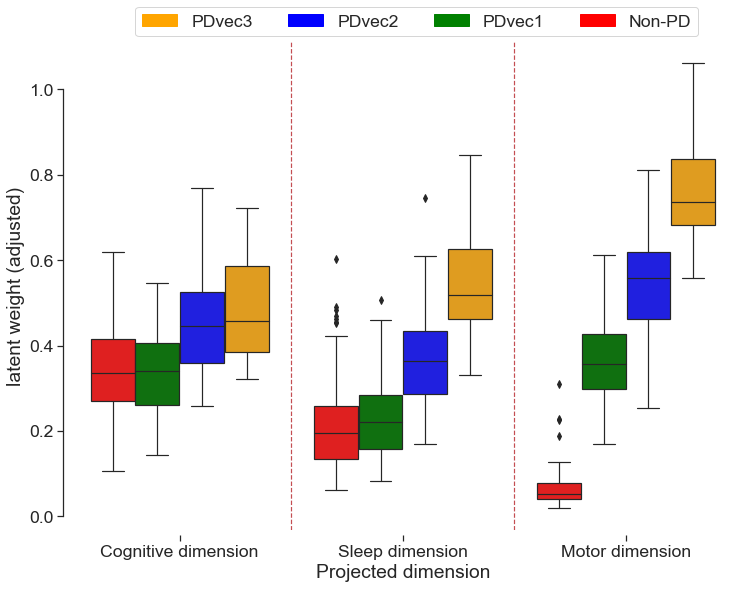

In [27]:
Z_melt = pd.melt(A, id_vars=['Subtypes'], var_name='Projected dimension', value_name='latent weight (adjusted)')
# Z_melt = Z_melt.replace(dimension_name)
# fig, ax = plt.subplots(figsize=(4*3, 3*3))
fig, ax = plt.subplots(1, gridspec_kw={'hspace': 0}, figsize=(4*3, 3*3))
sns.boxplot(x='Projected dimension', y='latent weight (adjusted)', hue='Subtypes', hue_order=['Non-PD', 'PDvec1', 'PDvec2', 'PDvec3'], data=Z_melt, palette=palette_progression, ax=ax)
ax.legend(handles=color_patch, bbox_to_anchor=(0.1, 1.01), loc='lower left', ncol=4, borderaxespad=0)
[plt.axvline(x, color = 'r', linestyle='--') for x in [0.5,1.5]]
# [plt.axvline(x, color = 'black', linestyle='--', alpha=0.1) for x in [-0.2,0,0.25]]

sns.despine(offset=5, trim=True)
ax.spines['bottom'].set_visible(False)
# fig.savefig('images/Fig7_box_plot', dpi=100, bbox_inches = "tight")

## Progression Actual Value Plots

### Dimensions plot

paper_experiment_flip_outlier
{'Sleep': ['a_state', 'NP1SLPD', 'NP1ANXS', 'SLPLMBMV', 'NP1DDS', 'DRMUMV', 'ESS1', 'TMTMTACT', 'NP1SLPN', 'DRMFIGHT', 'TMTORACT', 'ESS4', 'NP1DPRS', 'ESS7', 'DRMOBJFL', 'ESS2', 'DRMAGRAC', 'urinary', 'MVAWAKEN', 'ESS3', 'cardiovascular', 'TMSEX', 'DEPRS', 'ESS6', 'SLPINJUR', 'thermoregulatory', 'DRMVIVID', 'DRMREMEM', 'DRMNOCTB', 'NP1APAT', 'NP1LTHD', 'ESS8', 'CN346RSP', 'total', 'SLPDSTRB', 'NP1FATG', 'CNTRLSEX', 'a_trait', 'TMBUY', 'TMEAT', 'gastrointestinal_down', 'DRMVERBL', 'skin', 'NP1PAIN', 'HETRA', 'CNTRLEAT', 'ESS5', 'pupillomotor', 'RLS'], 'Motor': ['NP3RTALJ', 'NP2HOBB', 'NP3HMOVL', 'NP1URIN', 'NP3RIGLU', 'NP2TURN', 'NP3PTRML', 'NP2DRES', 'NP3RTALL', 'NP3RTALU', 'NP2HWRT', 'NP3FRZGT', 'NP2EAT', 'NP3RISNG', 'NP3RTARL', 'NP3FTAPL', 'NP3RTCON', 'NP3RIGLL', 'NP1CNST', 'NP2SALV', 'NP3RIGRU', 'gastrointestinal_up', 'NP2FREZ', 'NP2SWAL', 'NP1HALL', 'NP2HYGN', 'NP3PTRMR', 'NP3RTARU', 'NP3PRSPR', 'NP3TTAPL', 'NP2TRMR', 'NP2RISE', 'NP2SPCH', 'NP3FTAPR', 

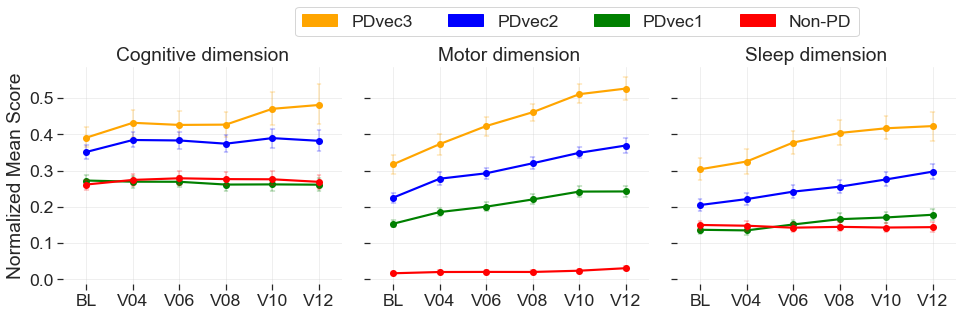

In [28]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
def create_progression_plot(cluster_given, selected_M_chosen, d_M_label_PD_HC):
    palette_progression = {'PD_h':'orange', 'PD_m': 'blue', 'PD_l':'green', 'HC':'red'}
    column_names = list(cluster_given.keys())
    b = create_multiple_columns(list(cluster_given.values()), column_names, selected_M_chosen, d_M_label_PD_HC['GMM'], agg_type='mean', sign_type=[None]*len(cluster_given))
    ground_truth_df = b.copy()
    columns = ['PD_h', 'PD_m', 'PD_l', 'HC']
    g = sns.factorplot(x="Visit ID", y='True Mean Score', hue="Categories", col='Feature',
                         data=ground_truth_df.sort_values(by=['Visit ID', 'Feature']),
                         hue_order=columns, col_wrap=len(cluster_given), height=3, sharex=True, sharey=True, palette=palette_progression)
    return ground_truth_df.sort_values(by=['Visit ID', 'Feature'])

def create_multiple_columns(col_list, column_names, feat_matrix, labels, agg_type='mean', sign_type=[None, None, None]):
    a = pd.DataFrame()# feat_matrix.loc[:,feat_matrix.columns.get_level_values(0).isin(col_list[0])].stack().mean(axis=1)
    for e, col in enumerate(col_list):
        if agg_type == 'mean':
            if sign_type[e] is not None:
                for k, sign in enumerate(sign_type[e]):
                    if sign=='-':
                        feat_matrix.loc[:,feat_matrix.columns.get_level_values(0).isin(col[k:k+1])] = 1 - feat_matrix.loc[:,feat_matrix.columns.get_level_values(0).isin(col[k:k+1])]
            temp = feat_matrix.loc[:,feat_matrix.columns.get_level_values(0).isin(col)].stack().mean(axis=1)
        elif agg_type == 'sum':
            if sign_type[e] is not None:
                for k, sign in enumerate(sign_type[e]):
                    if sign=='-':
                        feat_matrix.loc[:,feat_matrix.columns.get_level_values(0).isin(col[k:k+1])] = 1 - feat_matrix.loc[:,feat_matrix.columns.get_level_values(0).isin(col[k:k+1])]
            temp = feat_matrix.loc[:,feat_matrix.columns.get_level_values(0).isin(col)].stack().sum(axis=1)
        else:
            temp = feat_matrix.loc[:, feat_matrix.columns.get_level_values(0).isin(col)].stack()
            temp = temp.div(temp.mean(axis=0), axis=1)
            temp = temp.mean(axis=1)
        if e==0:
            a = pd.DataFrame(temp)
        else:
            a = pd.concat([a, temp], axis=1, join='inner')
    a.columns = column_names
    a = a.stack().reset_index().set_index("PATNO")
    b = pd.merge(labels, a, left_index=True, right_index=True)
    b.columns = ['Subtypes', 'Visit ID', 'Feature', 'True Mean Score']
    return b


cluster_each_dset = {}
for edash, edset in enumerate([datasets[0],]):
    print (edset)
    selected_M_orig = input_data['M_orig'][edset]
    fnm = '_3d'
    d_M_label_PD_HC = clustering_data['d_M_PD_HC_gmm_chosen'][edset]
    selected_M_chosen = clustering_data['d_selected_M_chosen'+fnm][edset]['V12']
    selected_M_chosen = clustering_data['d_selected_M_chosen'+fnm][edset]['V12']
    selected_M_chosen = input_data['M_chosen'][datasets[0]]
    cluster_given = input_data['nmf3_projection_cluster'][edset][0]
    cluster_each_dset[dset] = cluster_given
    column_names = list(cluster_given.keys())
    # print (column_names)
    print (cluster_given)
    selected_M_chosen = input_data['M_chosen'][dset]
    # b = create_multiple_columns(list(cluster_given.values()), column_names, selected_M_chosen, d_M_label_PD_HC['GMM'], agg_type='mean', sign_type=[None]*len(cluster_given))
    b = create_multiple_columns(list(cluster_given.values()), column_names, selected_M_chosen, Labels[['GMM_2d_adj']], agg_type='mean', sign_type=[None]*len(cluster_given))
    ground_truth_df = b.copy()
    mapping_function = {}
    palette_progression = {'PDvec3':'orange', 'PDvec2': 'blue', 'PDvec1':'green', 'Non-PD':'red'}

    subtype_order = ['PDvec3', 'PDvec2', 'PDvec1', 'Non-PD']
    dimension_replace = {'Sleep': 'Sleep dimension', 'Cognitive': 'Cognitive dimension', 'Motor': 'Motor dimension'}
    subtype_replace = {'PD_h':'PDvec3', 'PD_m': 'PDvec2', 'PD_l':'PDvec1', 'HC':'Non-PD'}
    latent_weight_replace = {'latent_weight1': 'Cognitive dimension', 'latent_weight2': 'Motor dimension', 
                        'latent_weight3': 'Sleep dimension'}
    subtype_cname = {'GMM': 'Subtypes'}

    ground_truth_df = ground_truth_df.replace(subtype_replace)
    ground_truth_df = ground_truth_df.replace(dimension_replace)
    cols_func = {"True Mean Score": "Mean Score"}
    ground_truth_df_new = ground_truth_df.rename(columns=cols_func)
    glist = list(ground_truth_df_new.groupby('Feature'))
    # fig, axs = plt.subplots(1, 3, figsize=[16, 4], sharex=True , sharey=True)
    fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharex=True , sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axslist = axs.reshape(-1)
    for e, k in enumerate(range(len(glist))):
        temp = glist[k][1]
        sns.pointplot(x="Visit ID", y= "Mean Score", hue="Subtypes", col="Feature",
                         data=temp.sort_values(by=['Visit ID', "Feature"]),
                         hue_order=subtype_order, col_wrap=len(cluster_given), sharex=True, 
                         sharey=False, palette=palette_progression, legend_out=False, errwidth=0.4, capsize=0.1, ax=axslist[e])
        axslist[e].set_xlabel('')
        axslist[e].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
        axslist[e].set_title(glist[k][0])
        axslist[e].spines['top'].set_visible(False)
        axslist[e].spines['right'].set_visible(False)
        axslist[e].spines['left'].set_visible(False)
        axslist[e].spines['bottom'].set_visible(False)
        axslist[e].grid(True, alpha=0.3)
        if e==0:
            axslist[e].legend(handles=color_patch, bbox_to_anchor=(0.8, 1.1), loc='lower left', ncol=4, numpoints=1 )
            axslist[e].set_ylabel('Normalized Mean Score')
        else:
            axslist[e].set_ylabel('')
            axslist[e].legend_.remove()

    # fig.savefig('images/Fig8_progression_dimension', dpi=100, bbox_inches = "tight")

### Specific features plot

In [29]:
P = input_data['P_d'][dset]
PX = P[['attribute', 'feature']].groupby('feature').agg(lambda x: list(x))# .reset_index()
feature_attribute_mapping = dict(zip(list(PX.index), list(PX['attribute'])))
# feature_attribute_mapping['hopkins_verbal'].remove('HVLTFPUN')
# feature_attribute_mapping['hopkins_verbal'].remove('HVLTFPRL')
feature_attribute_mapping['MCATOT'] = ['MCATOT']

In [30]:
reverse = list(P.iloc[:19]['attribute'])

In [31]:
columns_fig = 5
all_feats2 = [feature_attribute_mapping['aut']]
fnm = '_3d'
cluster_given_df = pd.DataFrame()
d_ground_truth_df = {}
split_size = {'Motor': 30, 'Sleep': 30, 'Cognitive': 30}
for e, edset in enumerate([dset,]):
    d_M_label_PD_HC = clustering_data['d_M_PD_HC_gmm_chosen'][edset]
    selected_M_chosen = selected_M_orig.copy() # clustering_data['d_selected_M_chosen'+fnm][dset]['V12']
    selected_M_chosen2 = clustering_data['d_selected_M_chosen'+fnm][edset]['V12']
    selected_M_chosen3 = input_data['M_chosen'][dset]
    cluster_given = clustering_data['d_cluster_kmeans'+fnm][edset]['V12']
    for csize in range(0, len(all_feats2), columns_fig):
        cluster_given = copy.deepcopy(feature_attribute_mapping)
        column_names = list(cluster_given.keys())
        b = create_multiple_columns(list(cluster_given.values()), column_names, input_data['M_orig'][datasets[0]], Labels['GMM'], agg_type='sum', sign_type=[None]*len(cluster_given))
        ground_truth_df = b.copy()
        b = create_multiple_columns(list(cluster_given.values()), column_names, selected_M_chosen3,Labels['GMM'], agg_type='mean', sign_type=[None]*len(cluster_given))
        ground_truth_df_adj = b.copy()
        columns = ['PD_h', 'PD_m', 'PD_l', 'HC']
        
ground_truth_df = ground_truth_df.replace(subtype_replace)
ground_truth_df = ground_truth_df.replace(dimension_replace)
cols_func = {"True Mean Score": "Total Score"}
ground_truth_df = ground_truth_df.rename(columns=cols_func)
glist2 = list(ground_truth_df.groupby('Feature'))

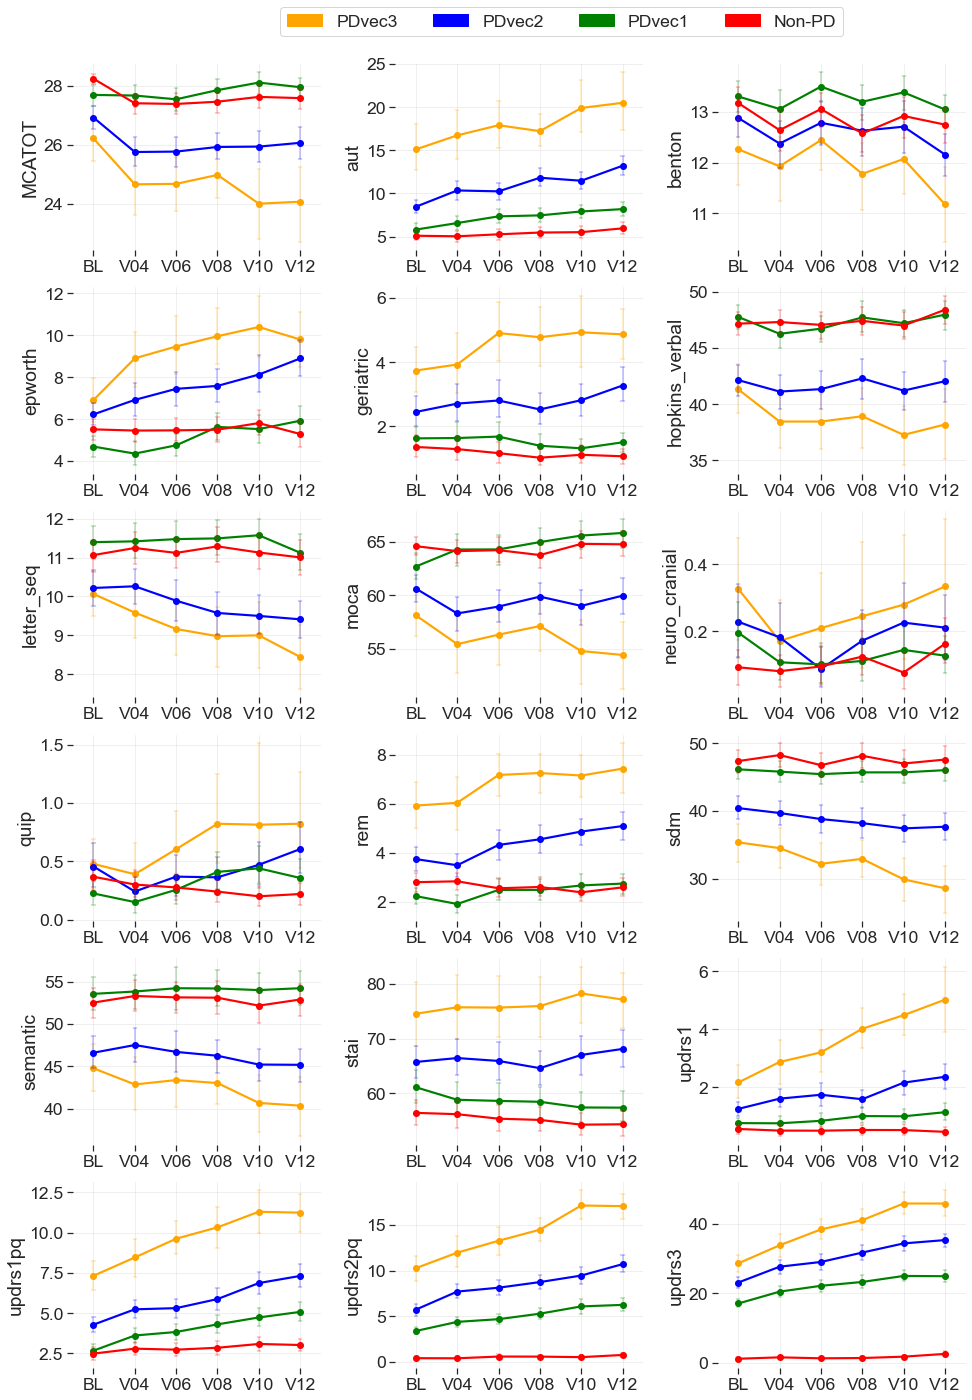

In [32]:
# fig, axs = plt.subplots(6, 3, figsize=[8.27, 11.69])
fig, axs = plt.subplots(6, 3, figsize=[16, 24])
plt.subplots_adjust(wspace=0.3, hspace=0.2)

axslist = axs.reshape(-1)
for e, k in enumerate(range(len(glist2))):
    temp = glist2[k][1]
    sns.pointplot(x="Visit ID", y= cols_func['True Mean Score'], hue="Subtypes", col='Feature',
                         data=temp.sort_values(by=['Visit ID', 'Feature']),
                         hue_order=subtype_order, col_wrap=len(cluster_given), sharex=True, 
                         sharey=True, palette=palette_progression, legend_out=False, errwidth=0.4, capsize=0.1, ax=axslist[e])
    axslist[e].set_xlabel('')
    axslist[e].set_ylabel(glist2[k][0])
    # labels = [item.get_text() for item in axslist[e].get_yticklabels()]
    # axslist[e].set_yticklabels([str(round(float(label), 0)) for label in labels])
    # break
    axslist[e].spines['left'].set_visible(False)    
    axslist[e].spines['top'].set_visible(False)
    axslist[e].spines['right'].set_visible(False)
    axslist[e].spines['bottom'].set_visible(False)
    axslist[e].grid(True, alpha=0.3)
    if e==0:
        axslist[e].legend(handles=color_patch, bbox_to_anchor=(0.8, 1.1), loc='lower left', ncol=4, numpoints=1 )
    else:
        axslist[e].legend_.remove()
# plt.savefig('images/progression_plot_phenotypes.tiff', dpi=100,bbox_inches='tight')
# fig.savefig('images/Fig8_progression_dimension_individual_feats', dpi=100, bbox_inches = "tight")

### RBD patients in the progression space

In [33]:
rem_dataframe = glist2[10][1].copy()
rem_dataframe_v12 = rem_dataframe[rem_dataframe['Visit ID']=='V12']
# rem_dataframe_v12.sort_values(by='Total Score', ascending=False)
rem_dataframe_v12['quantile'], bins = pd.qcut(rem_dataframe_v12['Total Score'], 3,  labels=False, retbins=True)
rem_dataframe_v12_rbd = rem_dataframe_v12[rem_dataframe_v12['Total Score'] >= 6]
mapping_rbd = dict(zip(list(rem_dataframe_v12.index), list(rem_dataframe_v12['quantile'])))

progression_space_3d = progression_space_3d_adj_list[-1].copy()
palette_progression_rbd = {'RBD': 'orange', 'Non-RBD': 'red'}
progression_space_3d['Subtypes'] = progression_space_3d.index.map(lambda x: mapping_rbd.get(x, np.nan))
progression_space_3d = progression_space_3d.dropna()

In [34]:
color_list = ['Green', 'Blue', 'Orange']

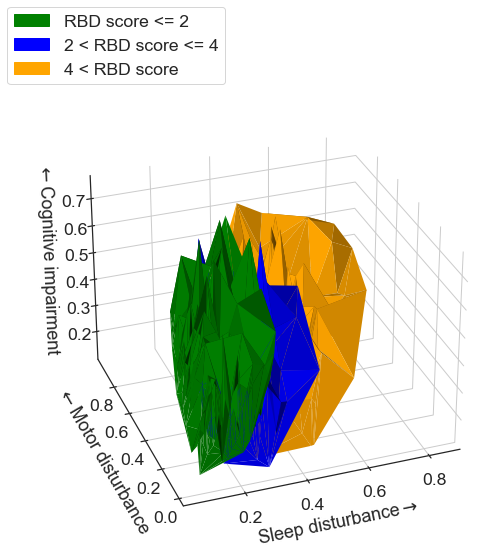

In [35]:

y_axis = 'Motor dimension'
z_axis = 'Cognitive dimension'
x_axis = 'Sleep dimension'
my_dpi=96

# my_color = progression_space_3d['Subtypes'].map(lambda x: palette_progression_rbd[x])
# result_rbd = progression_space_3d[progression_space_3d['Subtypes'] == 'RBD'].drop('Subtypes', 1)
# result_non_rbd = progression_space_3d[progression_space_3d['Subtypes'] == 'Non-RBD'].drop('Subtypes', 1)
result = progression_space_3d.drop('Subtypes', 1)

width = 11
fig = plt.figure(figsize=(width, 3*width/4))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter3D(result[x_axis], result[y_axis], result[z_axis], c=my_color, cmap='Greens')

# ax.scatter(result[x_axis], result[y_axis], result[z_axis], c=my_color)
# ax.plot_trisurf(result[x_axis], result[y_axis], result[z_axis], color='red', cmap='Reds', edgecolor='none', vmin=0, vmax=0.001);
for q in range(3):
    result = progression_space_3d[progression_space_3d['Subtypes']==q]
    ax.plot_trisurf(result[x_axis], result[y_axis], result[z_axis], color=color_list[q].lower(), linewidth=0., antialiased=True, shade=True)# , cmap= color_list[q] + 's', edgecolor='none', vmin=-0.01, vmax=0);
# ax.plot_trisurf(result_non_rbd[x_axis], result_non_rbd[y_axis], result_non_rbd[z_axis], color='blue', cmap='Blues', edgecolor='none', vmin=-0.01, vmax=0);


# for subtype, color in palette_progression_rbd.items():
#         x_meanpt = progression_space_3d.groupby('Subtypes').agg('mean').loc[subtype][x_axis]
#         y_meanpt = progression_space_3d.groupby('Subtypes').agg('mean').loc[subtype][y_axis]
#         z_meanpt = progression_space_3d.groupby('Subtypes').agg('mean').loc[subtype][z_axis]
#         mean_line = [(0, x_meanpt), (0, y_meanpt), (0, z_meanpt)]
#         ax.plot(mean_line[0], mean_line[1], mean_line[2], color=color, linewidth=4, markersize=12)
    
xAxisLine = ((min(result[x_axis]), max(result[x_axis])), (0, 0), (0,0))
yAxisLine = ((0, 0), (min(result[y_axis]), max(result[y_axis])), (0,0))
zAxisLine = ((0, 0), (0,0), (min(result[z_axis]), max(result[z_axis])))
ax.set_xlabel(r'{}$\rightarrow$'.format(dimension_name[x_axis]), labelpad=10, fontsize=18)
ax.set_ylabel(r'$\leftarrow${}'.format(dimension_name[y_axis]), labelpad=10, fontsize=18)
ax.set_zlabel(r'$\leftarrow${}'.format(dimension_name[z_axis]), labelpad=10, fontsize=18)
# ax.set_xlabel(x_axis, labelpad=10, fontsize=18)
# ax.set_ylabel(y_axis,labelpad=10, fontsize=18)
# ax.set_zlabel(z_axis, labelpad=10, fontsize=18)
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(elev=30., azim=250)
color_patch = []
legends=('RBD score <= {}'.format(int(bins[1])), '{} < RBD score <= {}'.format(int(bins[1]), int(bins[2])), '{} < RBD score '.format(int(bins[2])))
for lab, color in list(zip(list(legends), list(color_list))):
    color_patch.append(mpatches.Patch(color=color, label=lab))
ax.legend(handles=color_patch, bbox_to_anchor=(-0.1, 1), loc='lower left', ncol=1, numpoints=1 )
# plt.savefig('images/RBD_discussion_3d_{}'.format(i), dpi=100, bbox_inches = "tight")
plt.show()


## Patients with status change : Needs to be done

In [36]:
progression_space_3d = progression_space_3d_adj_list[-1].copy()

In [37]:
status_changed = [3109, 3077, 3908, 3323, 3071, 3075, 3160, 3274, 3965, 3362, 3191]

In [38]:
from definitions import ROOT_DIR_INSIDE
PPMI_CLINICAL_RAW_DATA_DIR_INSIDE = ROOT_DIR_INSIDE / 'raw_data/clinical/ppmi'

demgraphic_plus = pd.read_csv(PPMI_CLINICAL_RAW_DATA_DIR_INSIDE / 'all_data/demographicsPlus.csv' )
demgraphic_plus.index = demgraphic_plus['participant_id'].map(lambda x: int(x.split('-')[-1]) if x[:2]=='PP' else x)
mapping_diseases = {}
for disease in list(set(demgraphic_plus.loc[status_changed]['diagnosis_latest']).union(set(demgraphic_plus.loc[status_changed]['diagnosis_at_baseline']))):
    mapping_diseases[disease] = ''.join([i[0] for i in disease.split(' ')])

In [39]:
for enm, progression_space_3d in enumerate(progression_space_2d_adj_list):
    progression_space_3d = progression_space_3d.loc[status_changed].copy()
    progression_space_3d = pd.merge(progression_space_3d, demgraphic_plus.loc[status_changed].replace(mapping_diseases), left_index=True, right_index=True)
    progression_space_3d['labels'] = progression_space_3d['diagnosis_at_baseline'] + '->' + progression_space_3d['diagnosis_latest']

In [40]:
palette_progression

{'PDvec3': 'orange', 'PDvec2': 'blue', 'PDvec1': 'green', 'Non-PD': 'red'}

In [41]:
from matplotlib.markers import MarkerStyle

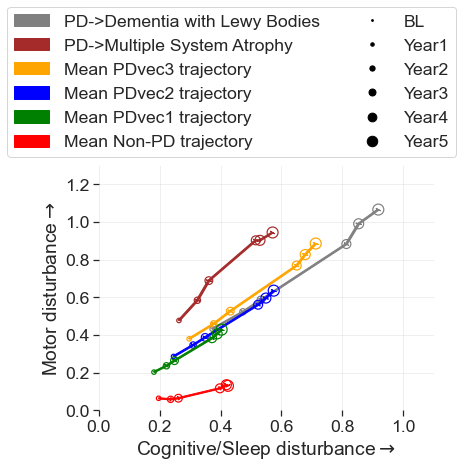

In [42]:
columns = 1
rows = 1
size_variation = 1.5
fig, axislist = plt.subplots(rows, columns, squeeze=False, figsize=(4*columns*size_variation, 3*rows*size_variation))
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.4)
axs = axislist.reshape(-1)
palette_progression_change = {'IP->DWLB': 'grey', 'IP->MSA':'brown'}
palette_progression_change.update(palette_progression)
end_x = {}
end_y = {}
start_x = {}
start_y = {}
use_labels = ['IP->DWLB', 'IP->MSA'] # 'NPNOND->AD', 'NPNOND->ED', 'NPNOND->IP', 'ET->NPNOND']

for enm, progression_space_3d in enumerate(progression_space_2d_adj_list):
    columns = [('Motor dimension', 'Cognitive dimension')]
    dummy = progression_space_3d.groupby('Subtypes').mean().reset_index().copy()
    # sns.scatterplot(data=dummy, x=columns[0][1], y=columns[0][0], hue='Subtypes', palette=palette_progression)
    progression_space_3d = progression_space_3d.loc[status_changed].copy()
    progression_space_3d = pd.merge(progression_space_3d, demgraphic_plus.loc[status_changed].replace(mapping_diseases), left_index=True, right_index=True)
    progression_space_3d['labels'] = progression_space_3d['diagnosis_at_baseline'] + '->' + progression_space_3d['diagnosis_latest']
    progression_space_3d = progression_space_3d[progression_space_3d['labels'].isin(use_labels)]
    progression_space_3d = progression_space_3d[['Motor dimension', 'Cognitive dimension', 'labels']]
    progression_space_3d = pd.concat([progression_space_3d, dummy.rename(columns={'Subtypes': 'labels'})], axis=0)
    color_patch = []
    for lab, color in palette_progression.items():
        color_patch.append(mpatches.Patch(color=color, label=lab))
    # 'full', 'left', 'right', 'bottom', 'top', 'none'.
    for i in range(1):
        ax = axs[0]
        # print (columns[i][0], np.var(progression_space_3d[columns[i][0]]))
        # print (columns[i][1], np.var(progression_space_3d[columns[i][1]]))
        colors = list(progression_space_3d['labels'].map(lambda x: palette_progression_change[x]))
        size = list(progression_space_3d['labels'].map(lambda x: (enm+1)*20 if x in ['IP->DWLB', 'IP->MSA'] else (enm+1)*20))
        # alpha = list(progression_space_3d['labels'].map(lambda x: 1 if x in ['IP->DWLB', 'IP->MSA'] else 0.3))
        ax.scatter(y=progression_space_3d[columns[i][0]], x=progression_space_3d[columns[i][1]], color=colors, s=size, marker=MarkerStyle(marker='o',fillstyle='none'))
        # sns.scatterplot(y=columns[i][0], hue='labels', x=columns[i][1], ax=ax, data=progression_space_3d, s=80,  palette=palette_progression_change,)
        # ax.legend_.remove()
        # start_y, start_x = list(progression_space_3d[progression_space_3d['labels']=='Non-PD'].loc[:, columns[i]].mean(axis=0))
        
        # ax.arrow(0, 0, start_x, start_y, width=0.01, color=palette_progression['Non-PD'], length_includes_head=True)
        
        
        for subtype in ['IP->DWLB', 'IP->MSA'] + ['PDvec1', 'PDvec2', 'PDvec3', 'Non-PD']:
            start_y[subtype], start_x[subtype] = copy.copy(end_y.get(subtype, 0)), copy.copy(end_x.get(subtype, 0))
            end_y[subtype], end_x[subtype] = list(progression_space_3d[progression_space_3d['labels']==subtype].loc[:, columns[i]].mean(axis=0))
            if not enm == 0:
                ax.arrow(start_x[subtype], start_y[subtype], end_x[subtype]-start_x[subtype], 
                     end_y[subtype]-start_y[subtype], width=0.007, color=palette_progression_change[subtype], length_includes_head=False, head_length=0)
            # if enm == 4 and subtype=='IP->MSA':
            #     ax.annotate('Y'+str(enm), xy=(end_x[subtype]+0.01, end_y[subtype]), fontsize=10)
            # else:
            #     if enm==0:
            #         ax.annotate('BL', xy=(end_x[subtype]-0.05, end_y[subtype]), fontsize=10)
            #     else:
            #         ax.annotate('Y'+str(enm), xy=(end_x[subtype]-0.05, end_y[subtype]), fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(True, alpha=0.3)
        limit_x = 1.1
        limit_y = 1.3
        ax.set_ylim(0, limit_y)
        ax.set_xlim(0, limit_x)
        ax.set_xticks(list(np.arange(0, limit_x+0.05, 0.2)), None)
        ax.set_yticks(list(np.arange(0, limit_y+0.05, 0.2)), None)
        # print (np.arange(0, 0.65, 0.05))
        empty_string_labels = [str(ep) for ep in range(len(np.arange(0, 0.65, 0.05)))]#['']*len(list(np.arange(0, 0.6, 0.05)))
        empty_string_labels_y = [str(ep) for ep in range(len(np.arange(0, 0.65, 0.05)))]
        ax.set_xlabel(r'{}$\rightarrow$'.format('Cognitive/Sleep disturbance'))
        ax.set_ylabel(r'{}$\rightarrow$'.format('Motor disturbance'))
    
    # ax.set_title(visits_list[enm] + ' (Year {})'.format(enm))
    # ax.legend(bbox_to_anchor=(0.8, 1.1), loc='lower left', ncol=4, numpoints=1 )
    color_patch = []
    circle_patch = []
    for lab, color in palette_progression_change.items():
        if lab == 'IP->DWLB':
            color_patch.append(mpatches.Patch(color=color, label='PD->Dementia with Lewy Bodies'))
        elif lab == 'IP->MSA':
            color_patch.append(mpatches.Patch(color=color, label='PD->Multiple System Atrophy'))
        else:
            color_patch.append(mpatches.Patch(color=color, label='Mean '+lab + ' trajectory'))
    for enm3, lab in enumerate(['BL', 'Year1', 'Year2', 'Year3', 'Year4', 'Year5']):
        circle_patch.append(plt.plot([],[], marker="o", ms=(enm3+1)*1.75, ls="", mec=None, color='black', label=lab)[0])
    
    ax.legend(handles=color_patch+circle_patch, bbox_to_anchor=(-0.3, 1), loc='lower left', ncol=2, numpoints=1 )
    # fig.savefig('images/progression_diagnosis_change', dpi=100, bbox_inches = "tight")